In [14]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from random import choices
from glob import glob
import xarray as xr
import datetime as dt

# **Inverse Problems Primer, continued.**

# II. Inverse Problem Formulation 2: Bayesian Probabilistic Approach
## A more general approach for the inverse problem formulation is to think about the observations (or equivalently, their errors) and forward model parameters as distributions. We implicitly did this for the observations in the previous example when we created the noise: 
### `noise = bias + scatter*np.random.randn(n_obs)`
### This represents sampling a normal distribution with mean $\mu = $ `bias` and standard deviation $\sigma = $ `scatter`. However, the optimal estimation approach with real observations does not require any assumptions about the distribution. 

## II.A. The Bayesian Problem Setup
### Recall Bayes' Theorem: $$ f_{B|Y=y}(\beta) \propto f_{Y|B=\beta}(y)f_B(\beta). $$ This equation is true for all distributions, but we interpret it in the context of our problem:
### [1] $B$ is the distribution of the parameters we want to infer, which we assign a prior distribution with density $f_B$.
### [2] $Y$ is the distribution of observations (or equivalently, their errors).
### [3] The function $f_{Y|B=\beta}$ is called the "likelihood" of Y taking a value of $y$ when $B=\beta$.
### [4] The density $f_{B|Y=y}$ describes the "posterior" distribution of $B$,

### In order to fully specify our problem, we have to specify the prior density $f_B$ and likelihood function $f_{Y|B=\beta}$. The models we specify encode our assumptions about 1) the quality of the observations $\hat{y}$, 2) the quality of our mapping between $\beta$ and $y$, and 3) our best estimate of our uncertainty in the parameters $\beta$. 


## II.B The Gaussian Assumption
### A typical approach (and one that is complementary to optimal estimation) is to assume Gaussian functions for our ingredients (ignoring normalization constants for now):
### [*Prior*] $$f_B(\beta) = \exp\left[-(\beta-\beta_0)^{\mathsf{T}}\Sigma^{-1}_{B}(\beta-\beta_0)\right]$$
### [*Likelihood*] $$f_{Y|B=\beta}(y) = \exp\left[-(y-F(x;\beta))^{\mathsf{T}}\Sigma^{-1}_{R}(y-F(x;\beta))\right]$$
### This leads to the posterior parameter density function:
### [*Posterior*] $$ f_{B|Y=y}(\beta) = \exp\left[-(y-F(x;\beta))^{\mathsf{T}}\Sigma^{-1}_{R}(y-F(x;\beta))-(\beta-\beta_0)^{\mathsf{T}}\Sigma^{-1}_{B}(\beta-\beta_0)\right]$$

### *Connection to least-squares*: Note that $$\log f_{B|Y=y}(\beta) = -|y-F(x;\beta)|_{\Sigma_R^{-1}} - |\beta-\beta_0|_{\Sigma_B^{-1}}.$$ This tells us that when we model the prior and likelihood with Gaussian distributions, the mode of the posterior $f_{B|Y=y}$ is also the minimizer of the weighted least squares cost function $$ J(\beta) = (y-F(x;\beta))^{\mathsf{T}}\Sigma^{-1}_{R}(y-F(x;\beta)) + (\beta-\beta_0)^{\mathsf{T}}\Sigma^{-1}_{B}(\beta-\beta_0) $$

## II.C Exploration with Gaussian Models
### [1] Data is a combination of model simulation from "true" parameters and unbiased Gaussian noise
### [2] Prior distribution is Gaussian with incorrect mean and uncorrelated covariances.
### [3] Likelihood is a Gaussian function

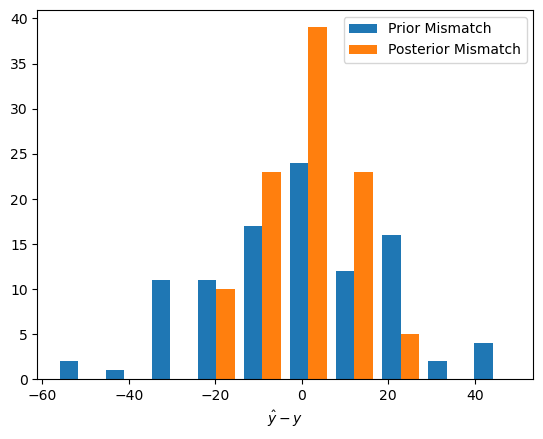

In [15]:
#np.random.seed(1)
n_obs = 100

# Noise is normally distributed with a bias and scatter
bias = 0.
scatter = 10.
noise = bias + scatter*np.random.randn(n_obs)
sig_R = np.diag(scatter**2*np.ones(n_obs))
sig_R_inv = np.diag(1/scatter**2*np.ones(n_obs))

# Model looks like y = -5x_1 + 5x_2
bet = np.array([-5,5])

# Create truth observations 
x1 = 10*np.random.randn(n_obs)
x2 = 10*np.random.randn(n_obs)
X = np.c_[(x1,x2)]
y = np.dot(X,bet)   #"truth" model output
yhat = y + noise     # noisy data

# Create Gaussian prior distribution for beta_1, beta_2 parameters
b1,b2 = np.mgrid[-10:0:.1, 0:10:.1]
pos = np.dstack((b1, b2))
bet_prior = [-4,6]
sig_B = [[1,0],[0,4]]
pdf_prior = multivariate_normal(bet_prior,sig_B).pdf(pos)
y_prior = np.dot(X,bet_prior)

#Likelihood based on Gaussian assumption above
likelihood = np.zeros(b1.shape)
for ii in range(b1.shape[0]):
    for jj in range(b1.shape[1]):
        mdm = yhat-np.dot(X,np.array([b1[ii,jj],b2[ii,jj]]))
        likelihood[ii,jj] = np.exp(-np.dot(mdm,np.dot(sig_R_inv,mdm)))

#Posterior is the normalized product of the likelihood and prior
pdf_post = pdf_prior*likelihood
pdf_post /= np.nansum(pdf_post)*0.1**2

#Mode of the posterior and simulated obs
bet_post = b1.flatten()[np.argmax(pdf_post)],b2.flatten()[np.argmax(pdf_post)]
y_post = np.dot(X,bet_post)

#Plot the prior and posterior mismatch with simulated data
plt.hist(np.c_[y_prior-yhat,y_post-yhat],label=['Prior Mismatch','Posterior Mismatch'])
plt.legend()
plt.gca().set_xlabel(r'$\hat{y}-y$');

### **Questions**
### [1] How does the prior fit to the data compare with the posterior fit to the data?
### [2] Why aren't the posterior mismatches zero?

## Let's explore the components of the Bayes' architecture.
### *The next sets of plots visualize the functions that make up the prior density, likelihood, and posterior density functions, both as 2D images as well as the marginal versions, in order to show how including data affects our knowledge of the parameters.*
### Prior Joint Density and Marginal Densities

Text(0.5, 0, 'Parameter $\\beta_1$')

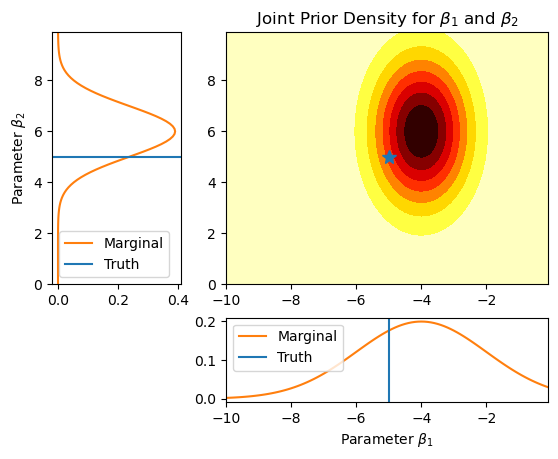

In [16]:
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[1,2.5], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

g = ax.contourf(b1,b2,pdf_prior,cmap=plt.cm.hot_r)
ax.plot(*bet,'*',ms=10)
ax.set_title('Joint Prior Density for $\\beta_1$ and $\\beta_2$')

p1 = axl.plot(pdf_prior.sum(1)*0.1,b2.mean(0),'tab:orange')
p2 = axl.axhline(bet[1])
axl.legend([p1[0],p2],['Marginal','Truth'])
axl.set_ylabel('Parameter $\\beta_2$')

p1 = axb.plot(b1.mean(1),pdf_prior.sum(0)*0.1,'tab:orange')
p2 = axb.axvline(bet[0])
axb.legend([p1[0],p2],['Marginal','Truth'])
axb.set_xlabel('Parameter $\\beta_1$')

### Likelihood

/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_73032/1487976402.py:6: RuntimeWarning: divide by zero encountered in log
  g = ax.contourf(b1,b2,np.log(likelihood),cmap=plt.cm.hot_r)
/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_73032/1487976402.py:10: RuntimeWarning: divide by zero encountered in log
  p1 = axl.plot(np.log(likelihood.sum(1)),b2.mean(0),'tab:orange')
/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_73032/1487976402.py:15: RuntimeWarning: divide by zero encountered in log
  p1 = axb.plot(b1.mean(1),np.log(likelihood.sum(0)),'tab:orange')


Text(0.5, 0, 'Parameter $\\beta_1$')

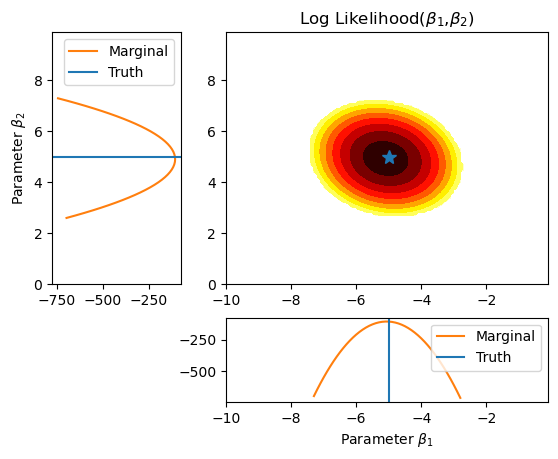

In [17]:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,2.5], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

g = ax.contourf(b1,b2,np.log(likelihood),cmap=plt.cm.hot_r)
ax.plot(*bet,'*',ms=10)
ax.set_title('Log Likelihood($\\beta_1$,$\\beta_2$)')

p1 = axl.plot(np.log(likelihood.sum(1)),b2.mean(0),'tab:orange')
p2 = axl.axhline(bet[1])
axl.legend([p1[0],p2],['Marginal','Truth'])
axl.set_ylabel('Parameter $\\beta_2$')

p1 = axb.plot(b1.mean(1),np.log(likelihood.sum(0)),'tab:orange')
p2 = axb.axvline(bet[0])
axb.legend([p1[0],p2],['Marginal','Truth'])
axb.set_xlabel('Parameter $\\beta_1$')

### Joint Posterior Density and Marginal Densities

Text(0.5, 0, 'Parameter $\\beta_1$')

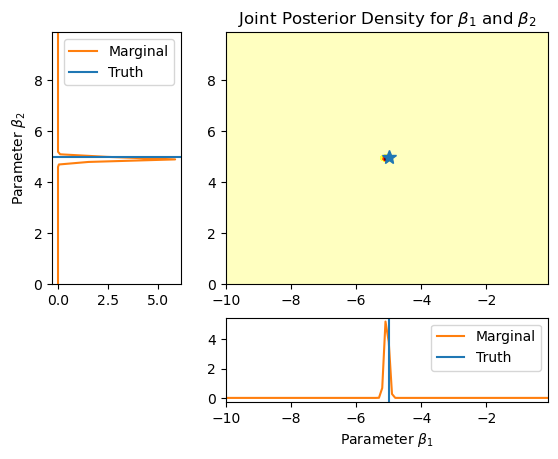

In [18]:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,2.5], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

g = ax.contourf(b1,b2,pdf_post,cmap=plt.cm.hot_r)
ax.plot(*bet,'*',ms=10)
ax.set_title('Joint Posterior Density for $\\beta_1$ and $\\beta_2$')

p1 = axl.plot(pdf_post.sum(1)*0.1,b2.mean(0),'tab:orange')
p2 = axl.axhline(bet[1])
axl.legend([p1[0],p2],['Marginal','Truth'])
axl.set_ylabel('Parameter $\\beta_2$')

p1 = axb.plot(b1.mean(1),pdf_post.sum(0)*0.1,'tab:orange')
p2 = axb.axvline(bet[0])
axb.legend([p1[0],p2],['Marginal','Truth'])
axb.set_xlabel('Parameter $\\beta_1$')

### Comparison of Prior and Posterior Marginal Densities

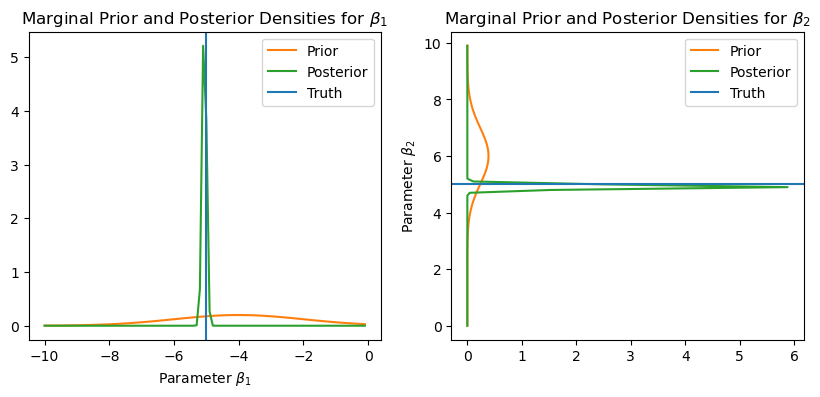

In [19]:
fig,axs = plt.subplots(1,2,figsize=(10,4))

ax = axs[0]
p1 = ax.plot(b1.mean(1),pdf_prior.sum(0)*0.1,'tab:orange')
p2 = ax.plot(b1.mean(1),pdf_post.sum(0)*0.1,'tab:green')
p3 = ax.axvline(bet[0])
ax.legend([p1[0],p2[0],p3],['Prior','Posterior','Truth'])
ax.set_xlabel('Parameter $\\beta_1$');
ax.set_title('Marginal Prior and Posterior Densities for $\\beta_1$')

ax = axs[1]
p1 = ax.plot(pdf_prior.sum(1)*0.1,b2.mean(0),'tab:orange')
p2 = ax.plot(pdf_post.sum(1)*0.1,b2.mean(0),'tab:green')
p3 = ax.axhline(bet[1])
ax.legend([p1[0],p2[0],p3],['Prior','Posterior','Truth'])
ax.set_ylabel('Parameter $\\beta_2$');
ax.set_title('Marginal Prior and Posterior Densities for $\\beta_2$');

### **Exercises**
### [1] Compute the mean parameters $\beta_1$ and $\beta_2$ for the prior and posterior. Recall that the mean for each parameter is the mean of the marginal density.
### [2] Compute the standard deviation of each marginal distribution for the prior and posterior.

In [20]:
### Compute the mean parameters

### Compute the marginal standard deviations


### **Questions**
### [1] How does the prior mean $\beta$ differ from the posterior mean $\beta$?
### [2] How does the prior spread differ from the posterior spread? 
### [3] How do we interpret these differences as "knowledge" on the parameters $\beta_1$ and $\beta_2$? Did inclusion of observations improve our understanding?

## Critical Thinking
### There were many assumptions made during this exercise. How might these results change if you changed the mean or covariance of the prior density function or picked a different family of density entirely? How about if the observations contained a nonzero bias that was not accounted for in our model?

### What happens if the forward model used in the likelihood calculation is different from the "true" model we used to generate the data? Perhaps the true relationship is nonlinear, but we often assume the forward model is linear in the absence of other information. 

### *Feel free to copy and paste the code below and do your own experiments!*